In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from cuml.ensemble import RandomForestRegressor as cuRF
from sklearn.ensemble import RandomForestRegressor as RF
import cudf
import cupy
import xgboost as xgb
from scripts.function_utils import past_timesteps, test_leave_house_out, total_averaged_metrics, add_energy_variation

#### Output file

In [2]:
sourceFile = open("../../gpu_logs/_porto_variation.txt", 'w')

### Load the data

In [3]:
df = pd.read_csv("../../data/porto.csv", decimal=",", index_col=[0])
## Leaving the first house (public building out) due to its different profile
df['Energy'] = df['Energy'].astype(np.float32)
df = df.iloc[:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
df['Time'] = pd.to_datetime(df['Time'])
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,0,2.964000
1,2019-01-01 00:15:00,0,2.584000
2,2019-01-01 00:30:00,0,3.071000
3,2019-01-01 00:45:00,0,2.694000
4,2019-01-01 01:00:00,0,2.569000
...,...,...,...
1791931,2020-01-01 22:45:00,50,0.753222
1791932,2020-01-01 23:00:00,50,0.716855
1791933,2020-01-01 23:15:00,50,0.735802
1791934,2020-01-01 23:30:00,50,0.485237


## Save Dataframe with past timesteps

In [4]:
number_of_timesteps = 96

In [5]:
# df_new = past_timesteps(df, number_of_timesteps)
# df_new

In [6]:
# df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
# df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
# df_new['Hour'] = df_new['Time'].dt.hour
# df_new

In [7]:
# df_selected = df_new[["Time","Location","lag_1","lag_2","lag_3","lag_4","lag_96","lag_192","lag_288","lag_384","lag_480","lag_576","lag_672","DayOfWeek","Hour","Energy"]]
# df_selected

In [8]:
#df_selected.to_csv("../../data/porto_full_selected.csv", index=False)

## Predict  5 folds with 10 random houses for test

In [9]:
df_test = pd.read_csv("../../data/porto_full_selected.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("../../data/porto_full_selected.csv", engine='c', dtype=float32_cols)
df

,Time,Location,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,2019-01-08 00:00:00,0,3.952000,3.803000,4.095000,3.926000,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000,1,0,4.940000
1,2019-01-08 00:15:00,0,4.940000,3.952000,3.803000,4.095000,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000,1,0,4.149000
2,2019-01-08 00:30:00,0,4.149000,4.940000,3.952000,3.803000,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000,1,0,4.401000
3,2019-01-08 00:45:00,0,4.401000,4.149000,4.940000,3.952000,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000,1,0,4.431000
4,2019-01-08 01:00:00,0,4.431000,4.401000,4.149000,4.940000,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000,1,1,3.988000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757659,2020-01-01 22:45:00,50,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943,2,22,0.753222
1757660,2020-01-01 23:00:00,50,0.753222,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914,2,23,0.716855
1757661,2020-01-01 23:15:00,50,0.716855,0.753222,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033,2,23,0.735802
1757662,2020-01-01 23:30:00,50,0.735802,0.716855,0.753222,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657,2,23,0.485237


In [10]:
cu_df = cudf.read_csv("../../data/porto_full_selected.csv")
cu_df

,Time,Location,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,2019-01-08 00:00:00,0,3.952000,3.803000,4.095000,3.926000,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000,1,0,4.940000
1,2019-01-08 00:15:00,0,4.940000,3.952000,3.803000,4.095000,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000,1,0,4.149000
2,2019-01-08 00:30:00,0,4.149000,4.940000,3.952000,3.803000,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000,1,0,4.401000
3,2019-01-08 00:45:00,0,4.401000,4.149000,4.940000,3.952000,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000,1,0,4.431000
4,2019-01-08 01:00:00,0,4.431000,4.401000,4.149000,4.940000,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000,1,1,3.988000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757659,2020-01-01 22:45:00,50,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943,2,22,0.753222
1757660,2020-01-01 23:00:00,50,0.753222,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914,2,23,0.716855
1757661,2020-01-01 23:15:00,50,0.716855,0.753222,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772034,2,23,0.735802
1757662,2020-01-01 23:30:00,50,0.735802,0.716855,0.753222,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657,2,23,0.485237


## Add Variation as a feature

In [11]:
df = add_energy_variation(df)
df

,Time,Location,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Variation,Energy
0,2019-01-08 00:00:00,0,3.952000,3.803000,4.095000,3.926000,2.615000,3.321000,3.066000,2.351000,2.851000,3.054000,2.964000,1,0,0.000000,4.940000
1,2019-01-08 00:15:00,0,4.940000,3.952000,3.803000,4.095000,2.634000,2.873000,3.152000,2.843000,3.102000,2.677000,2.584000,1,0,-0.160123,4.149000
2,2019-01-08 00:30:00,0,4.149000,4.940000,3.952000,3.803000,3.052000,3.407000,2.633000,2.949000,2.546000,3.522000,3.071000,1,0,0.060735,4.401000
3,2019-01-08 00:45:00,0,4.401000,4.149000,4.940000,3.952000,2.893000,2.673000,2.590000,2.605000,3.016000,2.729000,2.694000,1,0,0.006814,4.431000
4,2019-01-08 01:00:00,0,4.431000,4.401000,4.149000,4.940000,2.349000,2.390000,2.330000,3.023000,3.031000,2.368000,2.569000,1,1,-0.099980,3.988000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757659,2020-01-01 22:45:00,50,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943,2,22,-0.314699,0.753222
1757660,2020-01-01 23:00:00,50,0.753222,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914,2,23,-0.048295,0.716855
1757661,2020-01-01 23:15:00,50,0.716855,0.753222,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033,2,23,0.026417,0.735802
1757662,2020-01-01 23:30:00,50,0.735802,0.716855,0.753222,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657,2,23,-0.340542,0.485237


In [12]:
#df = df[["Time", "Location", "energy_lag_1", "energy_lag_3", "energy_lag_95", "energy_lag_671", "Energy"]]
#df

In [13]:
num_houses_test = 10
locations = []
for i in range(10):
    np.random.seed(i*4)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array([29, 11, 10, 22,  2, 28, 45, 32, 26,  4]),
 array([27,  6, 25,  7, 49, 18, 24,  4, 11, 14]),
 array([49, 35,  1, 50,  0, 22, 25, 31, 45, 32]),
 array([28, 47,  7, 42, 37, 29, 21, 49, 19,  8]),
 array([ 3, 35, 25, 37, 20, 23, 36, 21, 43, 40]),
 array([47,  4, 38, 18, 46, 43, 29, 12, 17,  8]),
 array([20,  8, 37,  5, 19, 33,  2, 30, 41, 21]),
 array([48, 11, 21, 35, 18, 29, 10, 47, 20, 37]),
 array([50, 16, 38, 36, 45,  8, 32, 12, 26,  2]),
 array([29, 11, 18, 32, 12, 35, 38, 16,  2,  8])]

In [14]:
## Number of NaNs
df.isna().sum().sum()

0

In [15]:
#kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
#locations = []
#for _, test_index in kf.split(df['Location'].unique()):
#    locations.append(test_index)
#locations

In [16]:
df.Location.value_counts()

0     34464
38    34464
28    34464
29    34464
30    34464
31    34464
32    34464
33    34464
34    34464
35    34464
36    34464
37    34464
39    34464
26    34464
40    34464
41    34464
42    34464
43    34464
44    34464
45    34464
46    34464
47    34464
48    34464
49    34464
27    34464
25    34464
1     34464
12    34464
2     34464
3     34464
4     34464
5     34464
6     34464
7     34464
8     34464
9     34464
10    34464
11    34464
13    34464
24    34464
14    34464
15    34464
16    34464
17    34464
18    34464
19    34464
20    34464
21    34464
22    34464
23    34464
50    34464
Name: Location, dtype: int64

### Linear Regression

In [ ]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr.append((rmse, wape, r2))

### XGBoost

In [ ]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.1, max_depth=12, n_estimators=500), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb.append((rmse, wape, r2))

### Random Forest

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df, cuRF(max_depth=12, n_estimators=500, max_batch_size=60), locations[i], sourceFile, split_timeseries=False, gpu=False)
    metrics_list_rf.append((rmse, wape, r2))

## Averaged Metrics

In [20]:
print("\n\n\n", file=sourceFile)

In [21]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

Total Averaged MSE: 0.211
Total Averaged WAPE: 30.447
Total Averaged R2: 0.767


In [22]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

Total Averaged MSE: 0.109
Total Averaged WAPE: 3.008
Total Averaged R2: 0.949


In [23]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

Total Averaged MSE: 0.118
Total Averaged WAPE: 3.348
Total Averaged R2: 0.941


In [24]:
sourceFile.close()

### Feature Importance

In [25]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.36878
Feature: 1, Score: 0.13030
Feature: 2, Score: 0.04016
Feature: 3, Score: 0.05550
Feature: 4, Score: 0.01239
Feature: 5, Score: 0.01944
Feature: 6, Score: 0.05442
Feature: 7, Score: 0.01800
Feature: 8, Score: 0.01121
Feature: 9, Score: 0.01634
Feature: 10, Score: 0.01489
Feature: 11, Score: 0.05957
Feature: 12, Score: 0.00668
Feature: 13, Score: 0.19233


In [26]:
model_xgb.feature_importances_

array([0.3687768 , 0.13029738, 0.04016029, 0.05550352, 0.01238866,
       0.01943515, 0.05442162, 0.01800257, 0.01120507, 0.01634087,
       0.01488566, 0.05957488, 0.00667975, 0.19232789], dtype=float32)

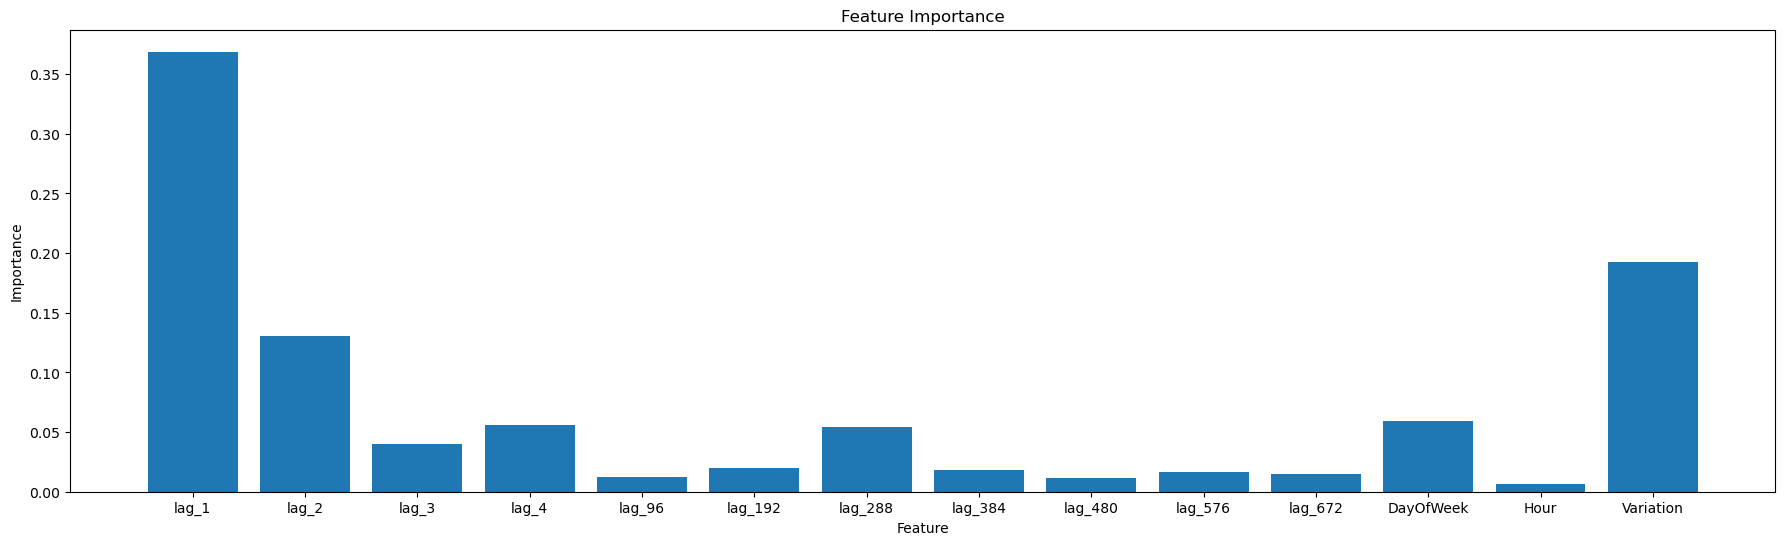

In [28]:
plt.figure(figsize=(22,6))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
#plt.savefig("images/porto_xgb_final7days_feature_importance.png")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

In [ ]:
features = feature_importance.nlargest(40).index
features

In [ ]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

In [ ]:
df_40.to_csv("data/porto_best40features.csv", index=False)

## Hyperparameter Tuning

In [ ]:
df_test = pd.read_csv("../../data/porto_full_selected.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df_tuning = pd.read_csv("../../data/porto_full_selected.csv", engine='c', dtype=float32_cols)
df_tuning.drop(['Time', 'Location'],axis=1, inplace=True)
df_tuning

In [ ]:
params_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

In [ ]:
params_xgb = { 
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7]
}

In [ ]:
train_features = df_tuning.drop('Energy', axis=1)
train_labels = df_tuning['Energy']
test_features = 0
test_labels = 0

### XGBoost Best Parameters

In [ ]:
xgb_model = xgb.XGBRegressor(tree_method="gpu_hist", seed=42)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = params_xgb, cv = 5, n_jobs = 4, verbose = 2, scoring="r2")

In [ ]:
grid_search.fit(train_features, train_labels)

In [ ]:
grid_search.best_params_
#{'colsample_bytree': 0.7,
#'learning_rate': 0.1,
#'max_depth': 10,
#'n_estimators': 1000}

In [ ]:
grid_search.best_score_

### Random Forest Best Parameters

In [ ]:
rf = RF()
grid_search_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, n_jobs = 16, verbose = 2, scoring="r2")

In [ ]:
grid_search_rf.fit(train_features, train_labels)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
base_model = xgb.XGBRegressor(n_estimators = 10, random_state = 42, tree_method="gpu_hist")
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

best_random = grid_search.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))